# Chapter 01. GMVP on individual stocks

- In this chpater, we are going to apply a global minimum variance portfolio(GMVP) on individual stocks.
- The portfolio performance of it will be used as a first benchmark for comparison

__Contents__

- [__Step 01. Loading stock data__](#Step-01.-Loading-stock-data)
- [__Step 02. Validation period performance__](#Step-02.-Validation-period-performance)
- [__Step 03. Test period performance__](#Step-03.-Test-period-performance)

reference : https://srome.github.io/Eigenvesting-II-Optimize-Your-Portfolio-With-Optimization/

---

## Step 01. Loading stock data

__1. Importing required libraries__

In [2]:
# for importing libraries again that is already imported, just in case that any change is made in libraries
%load_ext autoreload
%autoreload 2

# libraries for general work
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# for computing portfolio performance
from portfolio_performance_function import *

# Disable printing all warnings on python 
import warnings
warnings.filterwarnings("ignore")

# libraries related with plotting
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__2. Loading daily price of all stocks for indexing dates : `daily_price_df`__

In [3]:
# Loading
with open('./data/russel1000_daily_price_df.pickle', 'rb') as f:
    daily_price_df = pickle.load(f)
del daily_price_df.index.name

daily_price_df.head(3)

,MMM,ABT,ABMD,ACHC,ATVI,ADBE,AMD,AES,AMG,AFL,...,ZBRA,ZION,XEL,XRX,XLNX,YUM,BRK-B,HEI-A,LGF-A,JW-A
1999-11-01,26.186508,7.625059,10.2500,3.750,1.057096,17.013006,10.15625,22.383265,17.685398,5.895580,...,26.222221,44.172218,8.828288,59.627827,28.284966,4.807233,41.740002,1.899360,1.423901,12.179971
1999-11-02,26.430267,7.187653,10.3125,3.750,1.071191,16.888933,10.28125,22.780302,17.523146,6.068317,...,25.388889,45.481014,8.853581,57.188522,28.801279,4.733161,42.820000,1.891793,1.385417,12.134530
1999-11-03,26.325787,6.963037,10.2500,3.875,1.089984,17.075039,10.65625,22.209560,17.604273,6.150932,...,24.944445,44.920109,8.727110,57.324043,30.417568,4.651680,43.060001,1.755583,1.539352,11.725501


__3. Creating a list of all tickers : `all_tickers_list`__

In [4]:
all_tickers_list = list(daily_price_df.columns)

__4. Loading a grouped daily return data for validation : `daily_return_df_list_validation`__

In [5]:
# Loading
with open('./data/russel1000_daily_return_df_validation.pickle', 'rb') as f:
    daily_return_df_list_validation = pickle.load(f)
    
print(f"Total number of portfolio rebalancing  : {len(daily_return_df_list_validation)}" )
print(f"shape of dataframe : {daily_return_df_list_validation[0].shape}" )

Total number of portfolio rebalancing  : 47
shape of dataframe : (252, 590)


In [6]:
daily_return_df_list_validation[0].index

DatetimeIndex(['1999-11-02', '1999-11-03', '1999-11-04', '1999-11-05',
               '1999-11-08', '1999-11-09', '1999-11-10', '1999-11-11',
               '1999-11-12', '1999-11-15',
               ...
               '2000-10-17', '2000-10-18', '2000-10-19', '2000-10-20',
               '2000-10-23', '2000-10-24', '2000-10-25', '2000-10-26',
               '2000-10-27', '2000-10-30'],
              dtype='datetime64[ns]', length=252, freq=None)

In [7]:
print("---validation---")
print(f"first day date: {daily_return_df_list_validation[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_validation[-1].index[-1].date()}")

---validation---
first day date: 2000-10-31
last day date: 2011-10-20


In [8]:
# investment dates
investment_dates_validation = daily_price_df.loc['2000-10-31':'2011-10-20',:].index

In [9]:
len(investment_dates_validation)

2760

__5. Loading a grouped daily return data for test : `daily_return_df_list_test`__

In [10]:
# Loading
with open('./data/russel1000_daily_return_df_test.pickle', 'rb') as f:
    daily_return_df_list_test = pickle.load(f)
    
print(f"Total number of portfolio rebalancing : {len(daily_return_df_list_test)}" )
print(f"shape of dataframe : {daily_return_df_list_test[0].shape}" )

Total number of portfolio rebalancing : 31
shape of dataframe : (252, 590)


In [11]:
print("---test---")
print(f"first day date: {daily_return_df_list_test[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_test[-1].index[-1].date()}")

---test---
first day date: 2012-10-04
last day date: 2019-11-29


In [12]:
# investment dates
investment_dates_test = daily_price_df.loc['2012-10-04':'2019-11-29',:].index

In [13]:
len(investment_dates_test)

1800

---

## Step 02. Validation period performance

- We have 2 different time periods, validation_period and test_period for performing a portfolio optimization.
    - `Validation period` : 1999-11-02 ~ 2011-10-20
    - `Test period` : 2011-10-20 ~ 2019-11-29
- When we use computational clustering methods such as 'hierarchical clustering', we use validation period to decide upon which hyper-parameters produces the best outcome.
- Since we do not have any hyper-parameters in sector-based GMVP, we do not need to control hyper-parameters in this chapter.

<img src ="images/image_1.png" align='center' width = '700'>

__1. Portfolio optimization for validation period__
- __Input :__  
    1. daily_return_df_list_validation
- __Output :__  
    1. portfolio_weights_list  
    2. portfolio_daily_returns_list   
    3. in_sample_stdev_list  
    4. out_of_sample_stdev_list  

In [28]:
rebalancing_period = 60

portfolio_weights_df_list = []
daily_portfolio_returns_list = []
in_sample_stdev_list = []
out_of_sample_stdev_list = []

for time_index in tqdm(range(len(daily_return_df_list_validation))):

    selected_stocks_data = (daily_return_df_list_validation[time_index])

    cov_mat = selected_stocks_data.cov()
    cov_mat_values = cov_mat.values
    inv_cov_mat = np.linalg.pinv(cov_mat_values) # Use pseudo-inverse incase matrix is singular / ill-conditioned

    # get the portfolio weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    portfolio_weights = inv_dot_ones/ np.dot(inv_dot_ones, ones)
    portfolio_weights_df = pd.DataFrame(data= portfolio_weights, columns = ['weight'], index = all_tickers_list).sort_values(by=['weight'], ascending = False)
    portfolio_weights_df_list.append(portfolio_weights_df)
    
    in_sample_variance = np.dot(portfolio_weights, np.dot(cov_mat_values, portfolio_weights))
    in_sample_stdev = np.sqrt(in_sample_variance)

    # we should use 'index+1' ; we optimize portfolio at the time point 'index' and see how it goes for the time period from 'index' to 'index+1'
    if (time_index+1) < len(daily_return_df_list_validation):

        in_sample_stdev_list.append(in_sample_stdev)

        next_session_daily_return = daily_return_df_list_validation[time_index+1]
        weighted_returns = (next_session_daily_return * portfolio_weights)

        # using the portfolio weights, get the daily portfolio returns
        portfolio_daily_returns = weighted_returns.sum(axis=1)[-rebalancing_period:]
        out_of_sample_stdev_list.append(portfolio_daily_returns.std())
        daily_portfolio_returns_list.extend(portfolio_daily_returns)

daily_portfolio_returns_array = np.array(daily_portfolio_returns_list)

In [29]:
result_dict_validation = {'daily_return' : daily_portfolio_returns_array,
                          'in_sample_stdev' : in_sample_stdev_list,
                          'out_of_sample_stdev' : out_of_sample_stdev_list,
                          'portfolio_weights' : portfolio_weights_df_list}

In [31]:
# # Saving
# with open('result/1. GMVP_stocks_result_validation.pickle', 'wb') as f: # 
#     pickle.dump(result_dict_validation, f, pickle.HIGHEST_PROTOCOL)

In [32]:
# Loading
with open('result/1. GMVP_stocks_result_validation.pickle', 'rb') as f:
    result_dict_validation = pickle.load(f)

__2. Performance check-up__

In [33]:
# estimated_std
print(f"in-sample stdev : {pd.Series(in_sample_stdev_list).mean():.5f}")
# realized_std
print(f"out-of-sample stdev : {pd.Series(out_of_sample_stdev_list).mean():.5f}")
print('------------------------------')
# downside_std
print(f"downside_std : {get_single_downside_stdev(daily_portfolio_returns_array):.5f}")
# MDD
print(f"MDD : {get_maximum_drawdown(daily_portfolio_returns_array)*100:.2f}%")
# CVaR_95
print(f"CVaR_95 : {get_cvar_95(daily_portfolio_returns_array)*100:.2f}%")

in-sample stdev : 0.00352
out-of-sample stdev : 0.00673
------------------------------
downside_std : 0.00582
MDD : -50.25%
CVaR_95 : -1.35%


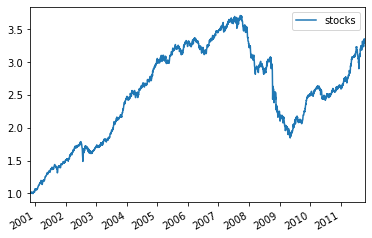

In [34]:
# cumulative wealth
(pd.DataFrame(daily_portfolio_returns_array, index=investment_dates_validation , columns=['stocks'])+1).cumprod().plot();

---

## Step 03. Test period performance

__1. Portfolio optimization for test period__
- __Input :__  
    1. daily_return_df_list_validation
- __Output :__  
    1. portfolio_weights_list  
    2. daily_portfolio_returns_array  
    3. in_sample_stdev_list  
    4. out_of_sample_stdev_list  

In [35]:
rebalancing_period = 60

portfolio_weights_list = []
daily_portfolio_returns_list = []
in_sample_stdev_list = []
out_of_sample_stdev_list = []

for time_index in tqdm(range(len(daily_return_df_list_test))):

    selected_stocks_data = (daily_return_df_list_test[time_index])

    cov_mat = selected_stocks_data.cov()
    cov_mat_values = cov_mat.values
    inv_cov_mat = np.linalg.pinv(cov_mat_values) # Use pseudo-inverse incase matrix is singular / ill-conditioned

    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    portfolio_weights = inv_dot_ones/ np.dot(inv_dot_ones, ones)
    portfolio_weights_df = pd.DataFrame(data= portfolio_weights, columns = ['weight'], index = all_tickers_list).sort_values(by=['weight'], ascending = False)
    portfolio_weights_df_list.append(portfolio_weights_df)
    
    in_sample_variance = np.dot(portfolio_weights, np.dot(cov_mat_values, portfolio_weights))
    in_sample_stdev = np.sqrt(in_sample_variance)

    # we should use 'index+1' ; we optimize portfolio at the time point 'index' and see how it goes for the time period from 'index' to 'index+1'
    if (time_index+1) < len(daily_return_df_list_test):

        in_sample_stdev_list.append(in_sample_stdev)

        next_session_daily_return = daily_return_df_list_test[time_index+1]
        weighted_returns = (next_session_daily_return * portfolio_weights)

        # out of 180 days, the first 160 days are overlappign with each other
        portfolio_daily_returns = weighted_returns.sum(axis=1)[-rebalancing_period:]
        out_of_sample_stdev_list.append(portfolio_daily_returns.std())
        daily_portfolio_returns_list.extend(portfolio_daily_returns)

daily_portfolio_returns_array = np.array(daily_portfolio_returns_list)

In [36]:
result_dict_test = {'daily_return' : daily_portfolio_returns_array,
                    'in_sample_stdev' : in_sample_stdev_list,
                    'out_of_sample_stdev' : out_of_sample_stdev_list,
                    'portfolio_weights' : portfolio_weights_df_list}

In [37]:
# # Saving
# with open('result/1. GMVP_stocks_result_test.pickle', 'wb') as f: # 
#     pickle.dump(result_dict_test, f, pickle.HIGHEST_PROTOCOL)

In [38]:
# Loading
with open('result/1. GMVP_stocks_result_test.pickle', 'rb') as f:
    result_dict_test = pickle.load(f)

__2. Performance check-up__

In [39]:
# estimated_std
print(f"in-sample stdev : {pd.Series(in_sample_stdev_list).mean():.5f}")
# realized_std
print(f"out-of-sample stdev : {pd.Series(out_of_sample_stdev_list).mean():.5f}")
print('------------------------------')
# downside_std
print(f"downside_std : {get_single_downside_stdev(daily_portfolio_returns_array):.5f}")
# MDD
print(f"MDD : {get_maximum_drawdown(daily_portfolio_returns_array)*100:.2f}%")
# CVaR_95
print(f"CVaR_95 : {get_cvar_95(daily_portfolio_returns_array)*100:.2f}%")

in-sample stdev : 0.00309
out-of-sample stdev : 0.00599
------------------------------
downside_std : 0.00435
MDD : -15.40%
CVaR_95 : -1.12%


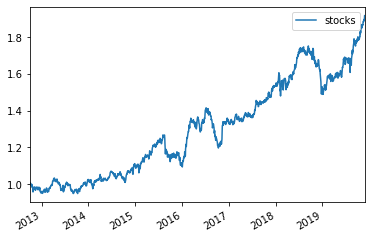

In [40]:
# cumulative wealth
(pd.DataFrame(daily_portfolio_returns_array, index=investment_dates_test , columns=['stocks'])+1).cumprod().plot();

__Portfolio weights__

In [41]:
time_index = 0

print(f"time index : {time_index}")
weight_df = portfolio_weights_df_list[time_index]
print(f"maximum weight: {weight_df.index[-1]}, {weight_df.iloc[0,0]*100:.2f}%")
print(f"minimum weight: {weight_df.index[0]}, {weight_df.iloc[-1,0]*100:.2f}%")

time index : 0
maximum weight: IR, 2.29%
minimum weight: ACGL, -2.12%


__Difference between `in-sample stdev` and `out-of-sample stdev`__

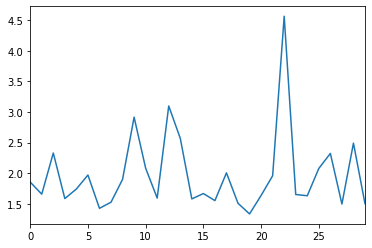

In [42]:
(pd.Series(out_of_sample_stdev_list)/pd.Series(in_sample_stdev_list)).plot()